# Angle Distribution Analysis

**Goal:** Test whether token vectors have **preferred orientations** or are **randomly scattered** through semantic space.

**Method:**
1. Choose a reference direction (top eigenvector of causal metric tensor M)
2. Generate random baseline: vocab_size random unit vectors
3. Compute angle of each vector (real and random) to reference direction
4. Compare distributions

**Interpretation:**
- **Random-like distribution:** Tokens are uniformly scattered (no directional structure)
- **Non-uniform distribution:** Tokens have preferred orientations (geometric structure!)

**Why this works:** In high-dimensional space, random vectors are nearly orthogonal to any reference direction. If tokens show a different angle distribution, that's evidence they're not randomly placed.

## Configuration

In [41]:
import sys
sys.path.append('..')

from azimuth.config import RANDOM_SEED

# Model
MODEL_NAME = 'Qwen/Qwen3-4B-Instruct-2507'

# Data paths
METRIC_TENSOR_PATH = '../data/vectors/causal_metric_tensor_qwen3_4b.pt'
RANDOM_BASELINE_PATH = '../data/vectors/random_baseline_unembedding.pt'

# Analysis parameters
NUM_BINS = 90  # Histogram bins (2° per bin for 180° range)
REFERENCE_TYPE = 'top_eigenvector'  # 'top_eigenvector' or 'random'

print(f"Configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Reference direction: {REFERENCE_TYPE}")
print(f"  Random seed: {RANDOM_SEED}")
print(f"  Histogram bins: {NUM_BINS}")

Configuration:
  Model: Qwen/Qwen3-4B-Instruct-2507
  Reference direction: top_eigenvector
  Random seed: 42
  Histogram bins: 90


## Setup

In [42]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM
from pathlib import Path

# Set random seed for reproducibility
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("✓ Imports complete")
print(f"✓ Random seed set to {RANDOM_SEED}")

✓ Imports complete
✓ Random seed set to 42


## Load Model and Metric Tensor

In [43]:
print("Loading model and metric tensor...\n")

# Load model (for unembedding matrix)
print(f"Loading model from {MODEL_NAME}...")
print("  This will take a minute...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map='cpu',
)

# Extract FULL unembedding matrix (all vocab)
gamma = model.lm_head.weight.data.to(torch.float32).cpu()  # [vocab_size, hidden_dim]
vocab_size, hidden_dim = gamma.shape

# Load metric tensor
print(f"\nLoading causal metric tensor from {METRIC_TENSOR_PATH}...")
metric_data = torch.load(METRIC_TENSOR_PATH, weights_only=False)
M = metric_data['M'].to(torch.float32).cpu()  # [hidden_dim, hidden_dim]

print(f"\n✓ All data loaded")
print(f"  Vocab size: {vocab_size:,}")
print(f"  Hidden dim: {hidden_dim:,}")
print(f"  Unembedding matrix shape: {gamma.shape}")
print(f"  Metric tensor shape: {M.shape}")

Loading model and metric tensor...

Loading model from Qwen/Qwen3-4B-Instruct-2507...
  This will take a minute...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]


Loading causal metric tensor from ../data/vectors/causal_metric_tensor_qwen3_4b.pt...

✓ All data loaded
  Vocab size: 151,936
  Hidden dim: 2,560
  Unembedding matrix shape: torch.Size([151936, 2560])
  Metric tensor shape: torch.Size([2560, 2560])


## Generate Random Baseline Unembedding Matrix

Generate `vocab_size` random unit vectors in `hidden_dim` space.

This serves as a **null model** - if tokens were placed randomly without semantic structure, this is what we'd expect.

In [44]:
print(f"\nGenerating random baseline unembedding matrix...")
print(f"  Shape: [{vocab_size:,}, {hidden_dim:,}]")
print(f"  Using seed: {RANDOM_SEED}")

# Generate random vectors from standard normal
gamma_random = torch.randn(vocab_size, hidden_dim, dtype=torch.float32)

# Normalize to unit vectors
gamma_random = gamma_random / torch.norm(gamma_random, dim=1, keepdim=True)

# Verify
norms = torch.norm(gamma_random, dim=1)
print(f"\n✓ Random matrix generated")
print(f"  Norm check: mean={norms.mean():.6f}, std={norms.std():.6f}")
print(f"  (Should be mean=1.0, std≈0.0 for unit vectors)")

# Save for future use
print(f"\nSaving random baseline to {RANDOM_BASELINE_PATH}...")
Path(RANDOM_BASELINE_PATH).parent.mkdir(parents=True, exist_ok=True)
torch.save({
    'gamma_random': gamma_random,
    'metadata': {
        'vocab_size': vocab_size,
        'hidden_dim': hidden_dim,
        'random_seed': RANDOM_SEED,
        'description': 'Random unit vectors as null model baseline for unembedding matrix',
    }
}, RANDOM_BASELINE_PATH)
print(f"✓ Saved ({gamma_random.element_size() * gamma_random.nelement() / 1e9:.2f} GB)")


Generating random baseline unembedding matrix...
  Shape: [151,936, 2,560]
  Using seed: 42

✓ Random matrix generated
  Norm check: mean=1.000000, std=0.000000
  (Should be mean=1.0, std≈0.0 for unit vectors)

Saving random baseline to ../data/vectors/random_baseline_unembedding.pt...
✓ Saved (1.56 GB)


## Choose Reference Direction

We'll use the **top eigenvector of M** (the direction of maximum causal variance).

In [45]:
print(f"\nComputing reference direction: {REFERENCE_TYPE}")

if REFERENCE_TYPE == 'top_eigenvector':
    print("  Computing eigendecomposition of M...")
    print("  (This may take a minute...)")
    
    eigenvalues, eigenvectors = torch.linalg.eigh(M)
    
    # Top eigenvector (largest eigenvalue)
    reference_direction = eigenvectors[:, -1]  # Last column = largest eigenvalue
    top_eigenvalue = eigenvalues[-1].item()
    
    print(f"\n✓ Reference direction: top eigenvector of M")
    print(f"  Corresponding eigenvalue: {top_eigenvalue:.2f}")
    print(f"  Direction norm: {torch.norm(reference_direction).item():.6f}")
    
elif REFERENCE_TYPE == 'random':
    reference_direction = torch.randn(hidden_dim, dtype=torch.float32)
    reference_direction = reference_direction / torch.norm(reference_direction)
    
    print(f"\n✓ Reference direction: random unit vector")
    print(f"  Direction norm: {torch.norm(reference_direction).item():.6f}")

else:
    raise ValueError(f"Unknown REFERENCE_TYPE: {REFERENCE_TYPE}")


Computing reference direction: top_eigenvector
  Computing eigendecomposition of M...
  (This may take a minute...)

✓ Reference direction: top eigenvector of M
  Corresponding eigenvalue: 94217.94
  Direction norm: 1.000000


## Compute Angles: Random Vectors

In [46]:
print("\nComputing angles for random vectors...")

# Dot products with reference direction (Euclidean)
dot_products_random = gamma_random @ reference_direction

# Cosine similarity (vectors are already normalized)
cosines_random = dot_products_random.numpy()

# Angles in degrees
angles_random_rad = np.arccos(np.clip(cosines_random, -1.0, 1.0))
angles_random_deg = np.degrees(angles_random_rad)

print(f"✓ Angles computed for {len(angles_random_deg):,} random vectors")
print(f"\nRandom angle statistics:")
print(f"  Mean: {angles_random_deg.mean():.2f}°")
print(f"  Std: {angles_random_deg.std():.2f}°")
print(f"  Range: [{angles_random_deg.min():.2f}°, {angles_random_deg.max():.2f}°]")
print(f"  Median: {np.median(angles_random_deg):.2f}°")


Computing angles for random vectors...
✓ Angles computed for 151,936 random vectors

Random angle statistics:
  Mean: 90.00°
  Std: 1.13°
  Range: [84.97°, 95.14°]
  Median: 90.00°


## Compute Angles: Token Vectors

In [47]:
print("\nComputing angles for token vectors...")

# Normalize token vectors (they're not necessarily unit norm)
gamma_normalized = gamma / torch.norm(gamma, dim=1, keepdim=True)

# Dot products with reference direction
dot_products_tokens = gamma_normalized @ reference_direction

# Cosine similarity
cosines_tokens = dot_products_tokens.numpy()

# Angles in degrees
angles_tokens_rad = np.arccos(np.clip(cosines_tokens, -1.0, 1.0))
angles_tokens_deg = np.degrees(angles_tokens_rad)

print(f"✓ Angles computed for {len(angles_tokens_deg):,} token vectors")
print(f"\nToken angle statistics:")
print(f"  Mean: {angles_tokens_deg.mean():.2f}°")
print(f"  Std: {angles_tokens_deg.std():.2f}°")
print(f"  Range: [{angles_tokens_deg.min():.2f}°, {angles_tokens_deg.max():.2f}°]")
print(f"  Median: {np.median(angles_tokens_deg):.2f}°")


Computing angles for token vectors...
✓ Angles computed for 151,936 token vectors

Token angle statistics:
  Mean: 93.26°
  Std: 1.02°
  Range: [90.99°, 101.65°]
  Median: 93.05°


## Statistical Comparison

Use Kolmogorov-Smirnov test to determine if distributions are significantly different.

In [48]:
from scipy import stats

print("\n" + "=" * 80)
print("STATISTICAL COMPARISON")
print("=" * 80)

# Kolmogorov-Smirnov test
ks_statistic, ks_pvalue = stats.ks_2samp(angles_random_deg, angles_tokens_deg)

print(f"\nKolmogorov-Smirnov test:")
print(f"  Statistic: {ks_statistic:.6f}")
print(f"  P-value: {ks_pvalue:.2e}")

if ks_pvalue < 0.001:
    print(f"\n✅ Distributions are SIGNIFICANTLY DIFFERENT (p < 0.001)")
    print(f"   Token vectors have non-random orientations!")
    print(f"   Evidence of geometric structure in unembedding space.")
elif ks_pvalue < 0.05:
    print(f"\n✓ Distributions are significantly different (p < 0.05)")
    print(f"  Some evidence of structure.")
else:
    print(f"\n❌ Distributions are NOT significantly different (p = {ks_pvalue:.3f})")
    print(f"   Token vectors appear randomly oriented.")
    print(f"   No evidence of preferred directions.")

# Mean difference
mean_diff = angles_tokens_deg.mean() - angles_random_deg.mean()
print(f"\nMean angle difference: {mean_diff:.2f}° (tokens - random)")

if abs(mean_diff) < 1.0:
    print(f"  → Negligible difference in central tendency")
elif mean_diff > 0:
    print(f"  → Tokens tend to be MORE orthogonal to reference direction")
else:
    print(f"  → Tokens tend to be MORE aligned with reference direction")


STATISTICAL COMPARISON

Kolmogorov-Smirnov test:
  Statistic: 0.978333
  P-value: 0.00e+00

✅ Distributions are SIGNIFICANTLY DIFFERENT (p < 0.001)
   Token vectors have non-random orientations!
   Evidence of geometric structure in unembedding space.

Mean angle difference: 3.26° (tokens - random)
  → Tokens tend to be MORE orthogonal to reference direction


## Visualization: Zoomed Histograms

Since both distributions are tightly concentrated, let's zoom in to the 80°-110° range.

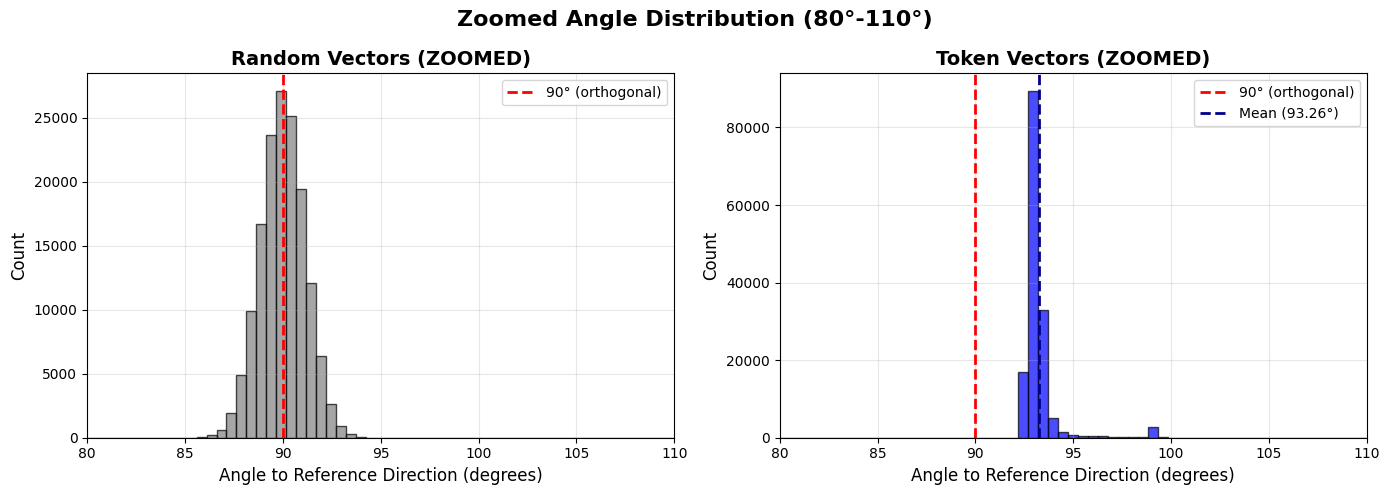

\n✓ Zoomed histograms plotted


In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Zoom to the relevant range
angle_min, angle_max = 80, 110
bins_zoomed = np.linspace(angle_min, angle_max, 60)

# Random vectors
ax1.hist(angles_random_deg, bins=bins_zoomed, alpha=0.7, color='gray', edgecolor='black')
ax1.axvline(90, color='red', linestyle='--', linewidth=2, label='90° (orthogonal)')
ax1.set_xlabel('Angle to Reference Direction (degrees)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title(f'Random Vectors (ZOOMED)', fontsize=14, fontweight='bold')
ax1.set_xlim(angle_min, angle_max)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Token vectors
ax2.hist(angles_tokens_deg, bins=bins_zoomed, alpha=0.7, color='blue', edgecolor='black')
ax2.axvline(90, color='red', linestyle='--', linewidth=2, label='90° (orthogonal)')
ax2.axvline(angles_tokens_deg.mean(), color='darkblue', linestyle='--', linewidth=2, 
           label=f'Mean ({angles_tokens_deg.mean():.2f}°)')
ax2.set_xlabel('Angle to Reference Direction (degrees)', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title(f'Token Vectors (ZOOMED)', fontsize=14, fontweight='bold')
ax2.set_xlim(angle_min, angle_max)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle(f'Zoomed Angle Distribution (80°-110°)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\\n✓ Zoomed histograms plotted")

## Polar Scatter Plot: Angle vs. Norm

**Mental picture:** Visualize vectors in polar coordinates:
- **Angle (θ):** From 0° (parallel) to 180° (antiparallel) to reference direction
- **Radius (r):** Vector norm (Euclidean length)

This gives a 2D slice through the high-dimensional space.

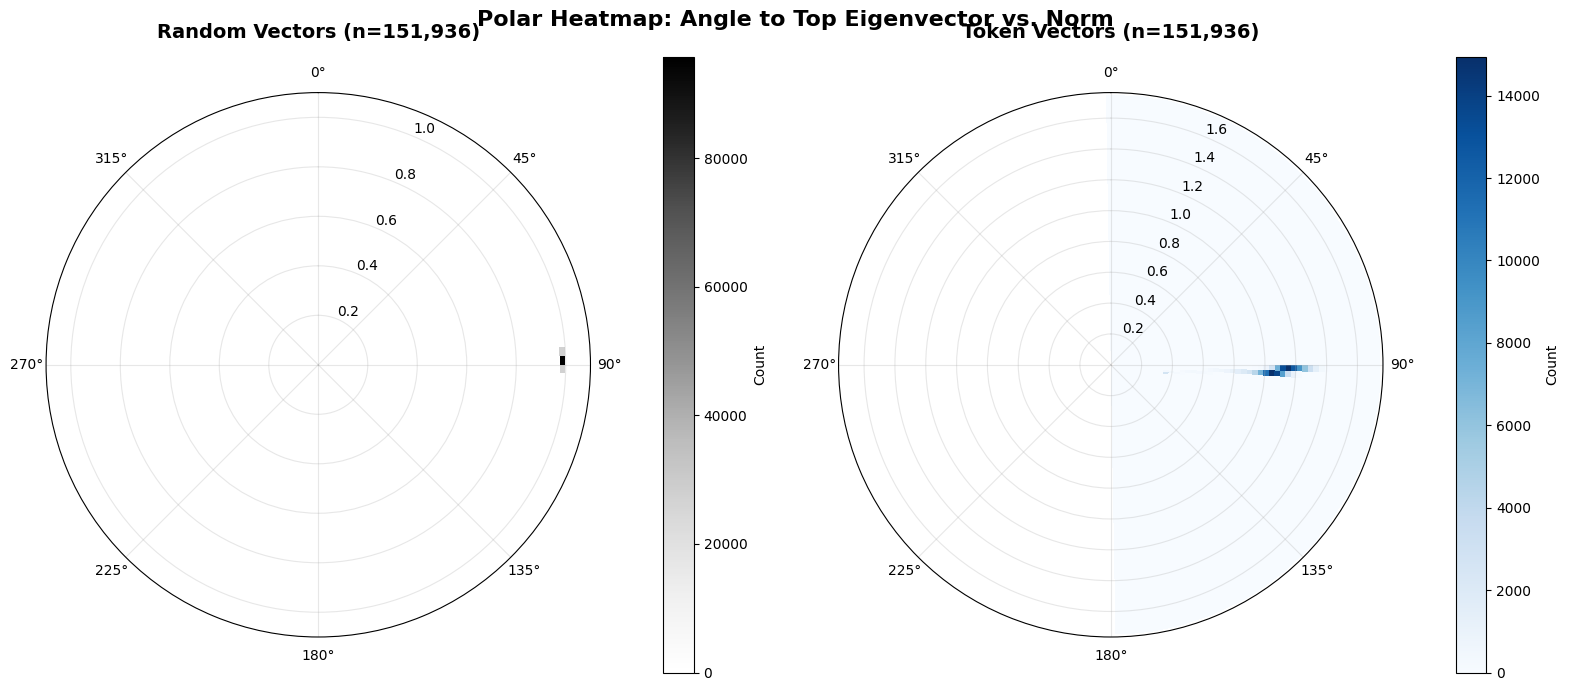


✓ Polar heatmap created (all 151,936 vectors)


In [50]:
# Get norms for ALL vectors (not sampled)
norms_random = torch.norm(gamma_random, dim=1).numpy()
norms_tokens = torch.norm(gamma, dim=1).numpy()

# Create 2D histogram bins for polar heatmap
angle_bins = np.linspace(0, np.pi, 90)  # 90 bins from 0 to 180°
norm_bins_random = np.linspace(0, norms_random.max() * 1.1, 50)
norm_bins_tokens = np.linspace(0, norms_tokens.max() * 1.1, 50)

# Compute 2D histograms
hist_random, angle_edges, norm_edges_random = np.histogram2d(
    angles_random_rad, norms_random, bins=[angle_bins, norm_bins_random]
)

hist_tokens, angle_edges, norm_edges_tokens = np.histogram2d(
    angles_tokens_rad, norms_tokens, bins=[angle_bins, norm_bins_tokens]
)

# Create meshgrid for plotting
angle_mesh_random, norm_mesh_random = np.meshgrid(angle_edges[:-1], norm_edges_random[:-1])
angle_mesh_tokens, norm_mesh_tokens = np.meshgrid(angle_edges[:-1], norm_edges_tokens[:-1])

# Create polar heatmap
fig = plt.figure(figsize=(16, 7))

# Random vectors
ax1 = fig.add_subplot(121, projection='polar')
pcm1 = ax1.pcolormesh(angle_mesh_random, norm_mesh_random, hist_random.T, 
                       cmap='Greys', shading='auto', vmin=0)
ax1.set_theta_direction(-1)  # Clockwise
ax1.set_theta_zero_location('N')  # 0° at top
ax1.set_ylim(0, norms_random.max() * 1.1)
ax1.set_title(f'Random Vectors (n={vocab_size:,})', fontsize=14, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3)
plt.colorbar(pcm1, ax=ax1, label='Count', pad=0.1)

# Token vectors
ax2 = fig.add_subplot(122, projection='polar')
pcm2 = ax2.pcolormesh(angle_mesh_tokens, norm_mesh_tokens, hist_tokens.T, 
                       cmap='Blues', shading='auto', vmin=0)
ax2.set_theta_direction(-1)  # Clockwise
ax2.set_theta_zero_location('N')  # 0° at top
ax2.set_ylim(0, norms_tokens.max() * 1.1)
ax2.set_title(f'Token Vectors (n={vocab_size:,})', fontsize=14, fontweight='bold', pad=20)
ax2.grid(True, alpha=0.3)
plt.colorbar(pcm2, ax=ax2, label='Count', pad=0.1)

plt.suptitle('Polar Heatmap: Angle to Top Eigenvector vs. Norm', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n✓ Polar heatmap created (all {vocab_size:,} vectors)")

## High-Resolution Zoomed Polar Heatmap

Maximum detail view of the actual data region.

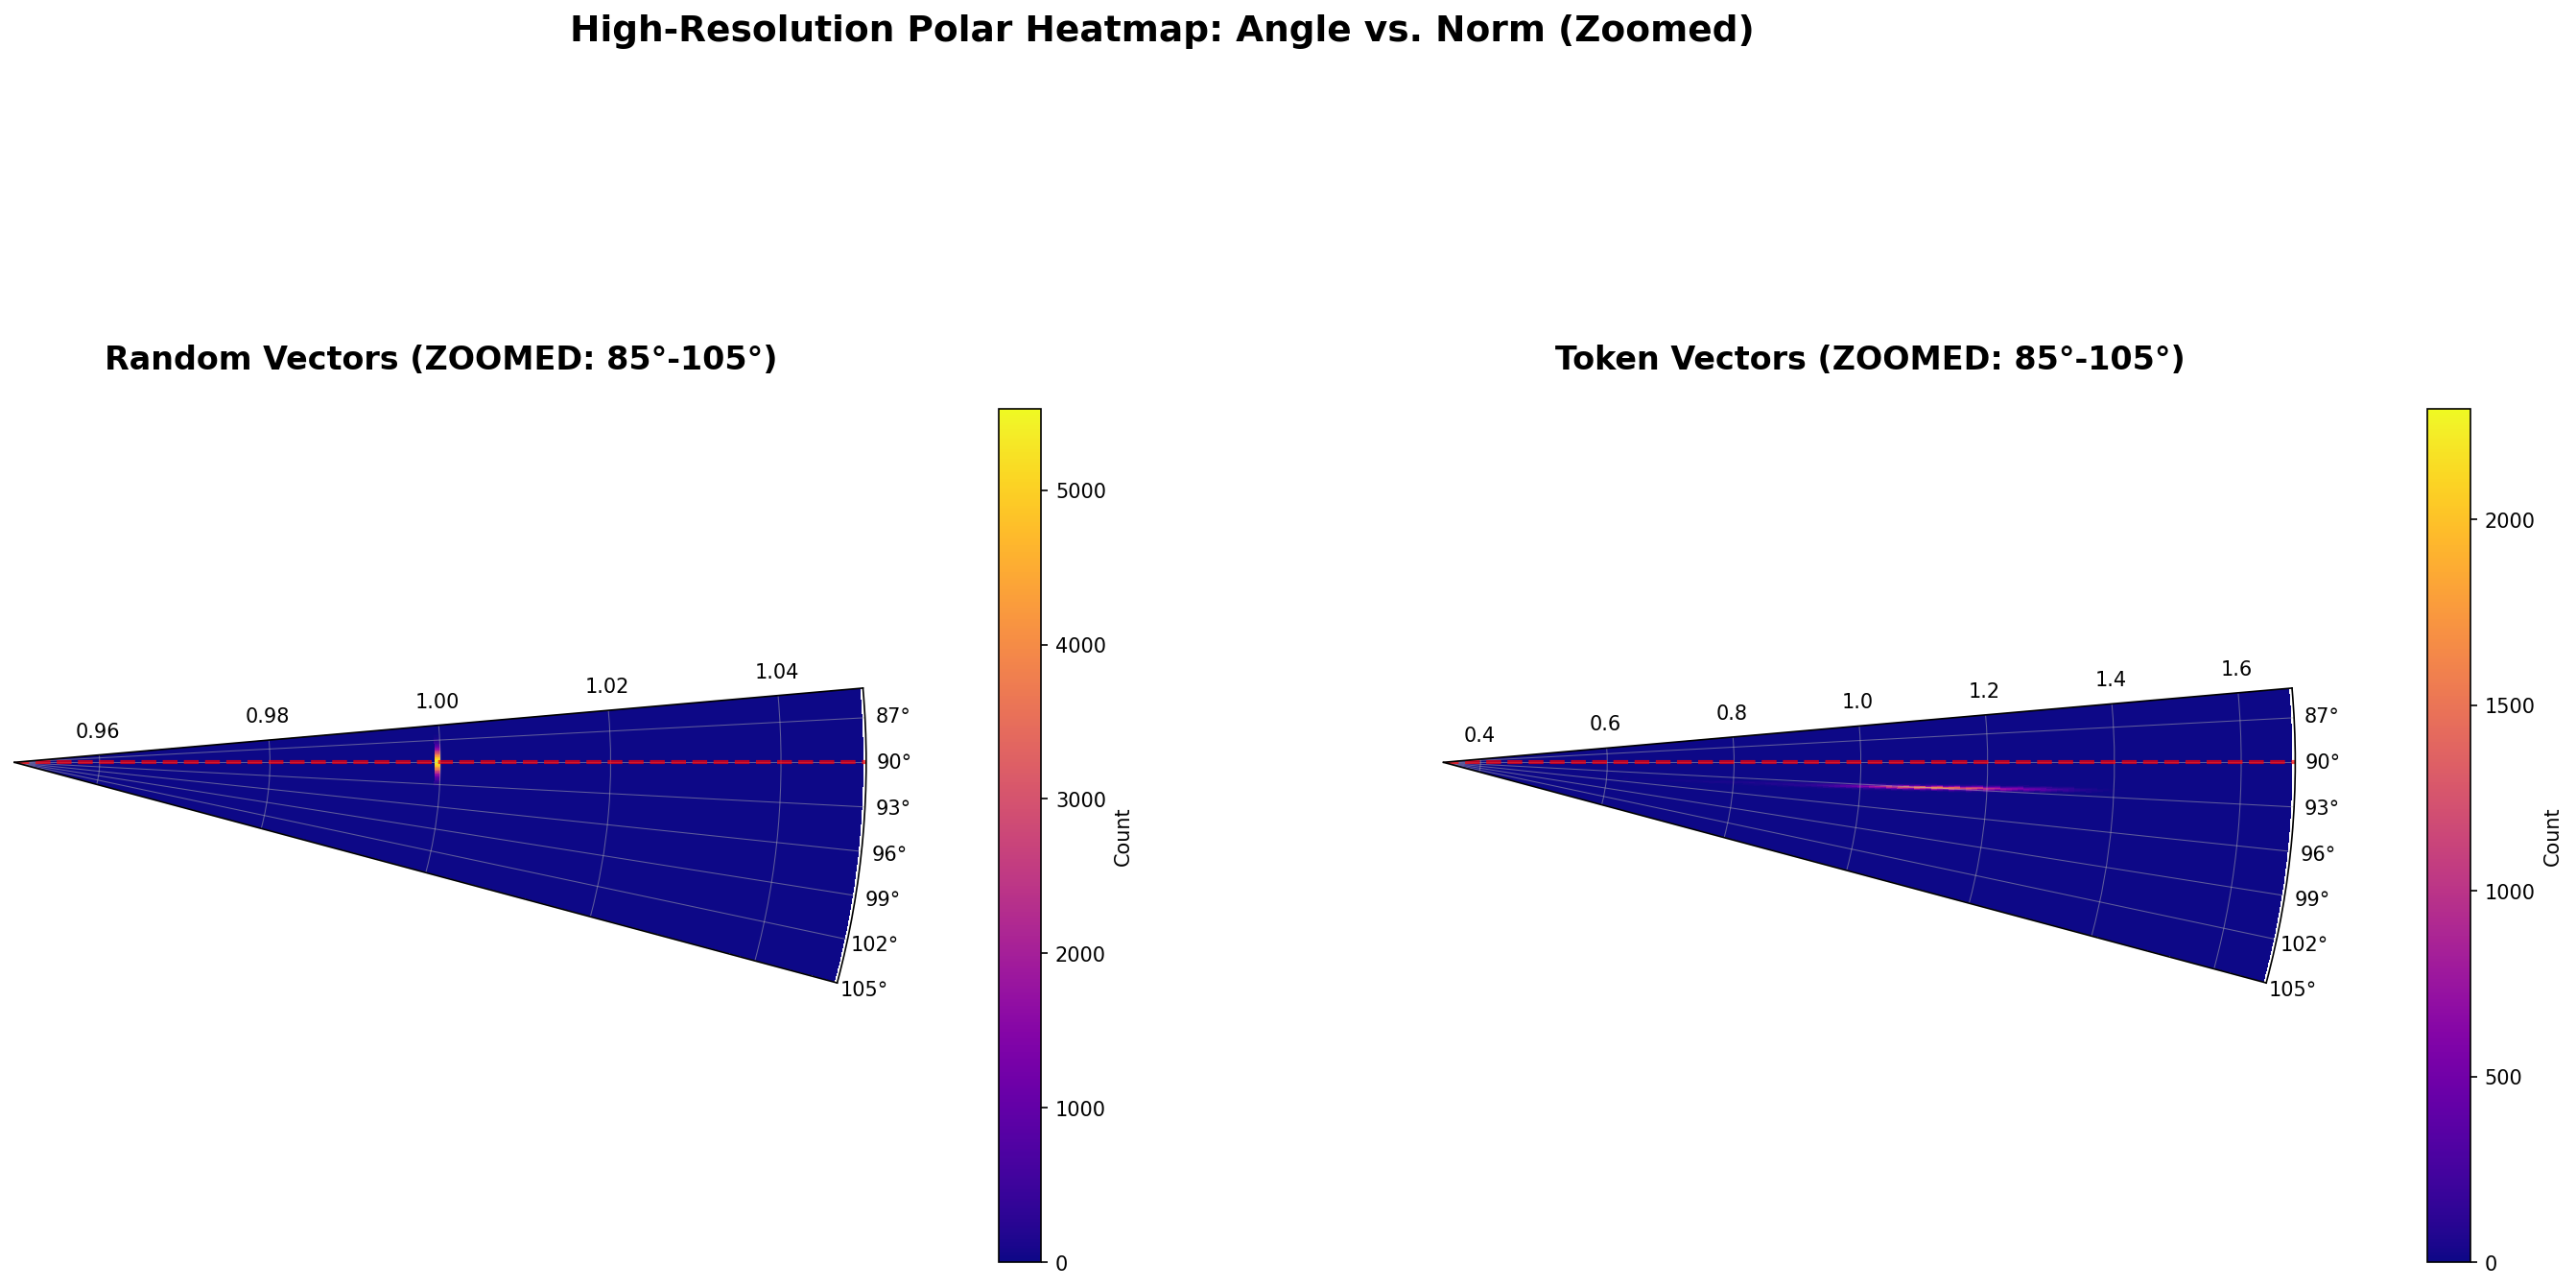


✓ High-resolution zoomed polar heatmap created
  Random vectors: 151,935 points
  Token vectors: 151,936 points
  Resolution: 200 angle bins × 150 norm bins
  Angle range: 85° to 105°
  Norm range (random): 0.950 to 1.050
  Norm range (tokens): 0.342 to 1.685


In [51]:
# Get norms for ALL vectors
norms_random = torch.norm(gamma_random, dim=1).numpy()
norms_tokens = torch.norm(gamma, dim=1).numpy()

# Define zoomed ranges based on actual data
angle_min_deg, angle_max_deg = 85, 105
angle_min_rad = np.radians(angle_min_deg)
angle_max_rad = np.radians(angle_max_deg)

norm_min_random = norms_random.min() * 0.95
norm_max_random = norms_random.max() * 1.05

norm_min_tokens = norms_tokens.min() * 0.95
norm_max_tokens = norms_tokens.max() * 1.05

# High-resolution bins
angle_bins = np.linspace(angle_min_rad, angle_max_rad, 200)  # 200 angle bins
norm_bins_random = np.linspace(norm_min_random, norm_max_random, 150)  # 150 norm bins
norm_bins_tokens = np.linspace(norm_min_tokens, norm_max_tokens, 150)

# Compute 2D histograms (only include vectors in the zoomed range)
mask_random = (angles_random_rad >= angle_min_rad) & (angles_random_rad <= angle_max_rad)
mask_tokens = (angles_tokens_rad >= angle_min_rad) & (angles_tokens_rad <= angle_max_rad)

hist_random, angle_edges_random, norm_edges_random = np.histogram2d(
    angles_random_rad[mask_random], 
    norms_random[mask_random], 
    bins=[angle_bins, norm_bins_random]
)

hist_tokens, angle_edges_tokens, norm_edges_tokens = np.histogram2d(
    angles_tokens_rad[mask_tokens], 
    norms_tokens[mask_tokens], 
    bins=[angle_bins, norm_bins_tokens]
)

# Create meshgrids
angle_mesh_random, norm_mesh_random = np.meshgrid(angle_edges_random[:-1], norm_edges_random[:-1])
angle_mesh_tokens, norm_mesh_tokens = np.meshgrid(angle_edges_tokens[:-1], norm_edges_tokens[:-1])

# High-resolution figure
fig = plt.figure(figsize=(20, 9), dpi=150)

# Random vectors
ax1 = fig.add_subplot(121, projection='polar')
pcm1 = ax1.pcolormesh(angle_mesh_random, norm_mesh_random, hist_random.T, 
                       cmap='plasma', shading='auto', vmin=0)
ax1.set_theta_direction(-1)
ax1.set_theta_zero_location('N')
ax1.set_ylim(norm_min_random, norm_max_random)
ax1.set_xlim(angle_min_rad, angle_max_rad)
ax1.set_title(f'Random Vectors (ZOOMED: {angle_min_deg}°-{angle_max_deg}°)', 
              fontsize=16, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.5, linewidth=0.5)
cbar1 = plt.colorbar(pcm1, ax=ax1, label='Count', pad=0.1, fraction=0.046)
cbar1.ax.tick_params(labelsize=10)

# Add reference line at 90°
ax1.plot([np.radians(90), np.radians(90)], [norm_min_random, norm_max_random], 
         'r--', linewidth=2, alpha=0.7, label='90°')

# Token vectors
ax2 = fig.add_subplot(122, projection='polar')
pcm2 = ax2.pcolormesh(angle_mesh_tokens, norm_mesh_tokens, hist_tokens.T, 
                       cmap='plasma', shading='auto', vmin=0)
ax2.set_theta_direction(-1)
ax2.set_theta_zero_location('N')
ax2.set_ylim(norm_min_tokens, norm_max_tokens)
ax2.set_xlim(angle_min_rad, angle_max_rad)
ax2.set_title(f'Token Vectors (ZOOMED: {angle_min_deg}°-{angle_max_deg}°)', 
              fontsize=16, fontweight='bold', pad=20)
ax2.grid(True, alpha=0.5, linewidth=0.5)
cbar2 = plt.colorbar(pcm2, ax=ax2, label='Count', pad=0.1, fraction=0.046)
cbar2.ax.tick_params(labelsize=10)

# Add reference line at 90°
ax2.plot([np.radians(90), np.radians(90)], [norm_min_tokens, norm_max_tokens], 
         'r--', linewidth=2, alpha=0.7, label='90°')

plt.suptitle('High-Resolution Polar Heatmap: Angle vs. Norm (Zoomed)', 
             fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n✓ High-resolution zoomed polar heatmap created")
print(f"  Random vectors: {mask_random.sum():,} points")
print(f"  Token vectors: {mask_tokens.sum():,} points")
print(f"  Resolution: 200 angle bins × 150 norm bins")
print(f"  Angle range: {angle_min_deg}° to {angle_max_deg}°")
print(f"  Norm range (random): {norm_min_random:.3f} to {norm_max_random:.3f}")
print(f"  Norm range (tokens): {norm_min_tokens:.3f} to {norm_max_tokens:.3f}")

## Interactive Plotly Scatterplot: All 152k Points

**Full resolution interactive visualization** - pan, zoom, hover for details.

Uses WebGL for performance with large datasets.

In [52]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Get causal norms (we already have Euclidean norms)
causal_norms_random = torch.sqrt(torch.sum(gamma_random @ M * gamma_random, dim=1)).numpy()
causal_norms_tokens = torch.sqrt(torch.sum(gamma @ M * gamma, dim=1)).numpy()

print("Computing causal norms...")
print(f"  Random causal norms: {causal_norms_random.min():.2f} to {causal_norms_random.max():.2f}")
print(f"  Token causal norms: {causal_norms_tokens.min():.2f} to {causal_norms_tokens.max():.2f}")

# Create subplot figure with two polar plots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Random Vectors (n=151,936)', 'Token Vectors (n=151,936)'),
    specs=[[{'type': 'polar'}, {'type': 'polar'}]]
)

# Random vectors (using scattergl for WebGL acceleration)
fig.add_trace(
    go.Scatterpolar(
        r=causal_norms_random,
        theta=np.degrees(angles_random_rad),  # Plotly wants degrees
        mode='markers',
        marker=dict(
            size=2,
            color=causal_norms_random,
            colorscale='Greys',
            opacity=0.5,
            colorbar=dict(
                title="Causal Norm<br>(logometers)",
                x=-0.15,
                len=0.5
            )
        ),
        name='Random',
        hovertemplate='<b>Random Vector</b><br>' +
                      'Angle: %{theta:.2f}°<br>' +
                      'Causal Norm: %{r:.2f} logo<br>' +
                      '<extra></extra>'
    ),
    row=1, col=1
)

# Token vectors
fig.add_trace(
    go.Scatterpolar(
        r=causal_norms_tokens,
        theta=np.degrees(angles_tokens_rad),
        mode='markers',
        marker=dict(
            size=2,
            color=causal_norms_tokens,
            colorscale='Blues',
            opacity=0.5,
            colorbar=dict(
                title="Causal Norm<br>(logometers)",
                x=1.15,
                len=0.5
            )
        ),
        name='Tokens',
        hovertemplate='<b>Token Vector</b><br>' +
                      'Angle: %{theta:.2f}°<br>' +
                      'Causal Norm: %{r:.2f} logo<br>' +
                      '<extra></extra>'
    ),
    row=1, col=2
)

# Update layout
fig.update_layout(
    title=dict(
        text='Interactive Polar Scatter: Angle to Top Eigenvector vs. Causal Norm',
        font=dict(size=20, family='Arial Black')
    ),
    height=700,
    width=1400,
    showlegend=False,
    polar=dict(
        radialaxis=dict(
            title='Causal Norm (logometers)',
            gridcolor='lightgray',
        ),
        angularaxis=dict(
            gridcolor='lightgray',
            direction='clockwise',
            rotation=90  # 0° at top
        )
    ),
    polar2=dict(
        radialaxis=dict(
            title='Causal Norm (logometers)',
            gridcolor='lightgray',
        ),
        angularaxis=dict(
            gridcolor='lightgray',
            direction='clockwise',
            rotation=90
        )
    )
)

fig.show()

print(f"\n✓ Interactive Plotly visualization created!")
print(f"  - Pan: Click and drag")
print(f"  - Zoom: Scroll or use zoom tools")
print(f"  - Hover: See individual point details")
print(f"  - Reset: Double-click to reset view")

Computing causal norms...
  Random causal norms: 50.24 to 59.00
  Token causal norms: 21.35 to 85.29



✓ Interactive Plotly visualization created!
  - Pan: Click and drag
  - Zoom: Scroll or use zoom tools
  - Hover: See individual point details
  - Reset: Double-click to reset view


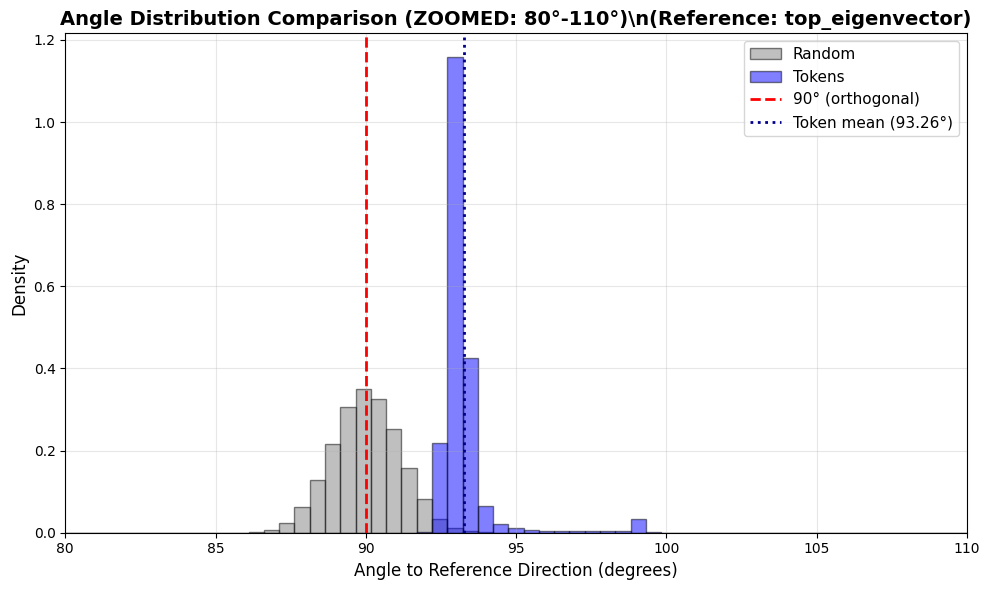


✓ Overlaid histogram plotted (zoomed)


In [53]:
fig, ax = plt.subplots(figsize=(10, 6))

# Zoom to relevant range
angle_min, angle_max = 80, 110
bins_zoomed = np.linspace(angle_min, angle_max, 60)

ax.hist(angles_random_deg, bins=bins_zoomed, alpha=0.5, color='gray', label='Random', edgecolor='black', density=True)
ax.hist(angles_tokens_deg, bins=bins_zoomed, alpha=0.5, color='blue', label='Tokens', edgecolor='black', density=True)
ax.axvline(90, color='red', linestyle='--', linewidth=2, label='90° (orthogonal)')
ax.axvline(angles_tokens_deg.mean(), color='darkblue', linestyle=':', linewidth=2, 
          label=f'Token mean ({angles_tokens_deg.mean():.2f}°)')

ax.set_xlabel('Angle to Reference Direction (degrees)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'Angle Distribution Comparison (ZOOMED: 80°-110°)\\n(Reference: {REFERENCE_TYPE})', fontsize=14, fontweight='bold')
ax.set_xlim(angle_min, angle_max)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Overlaid histogram plotted (zoomed)")

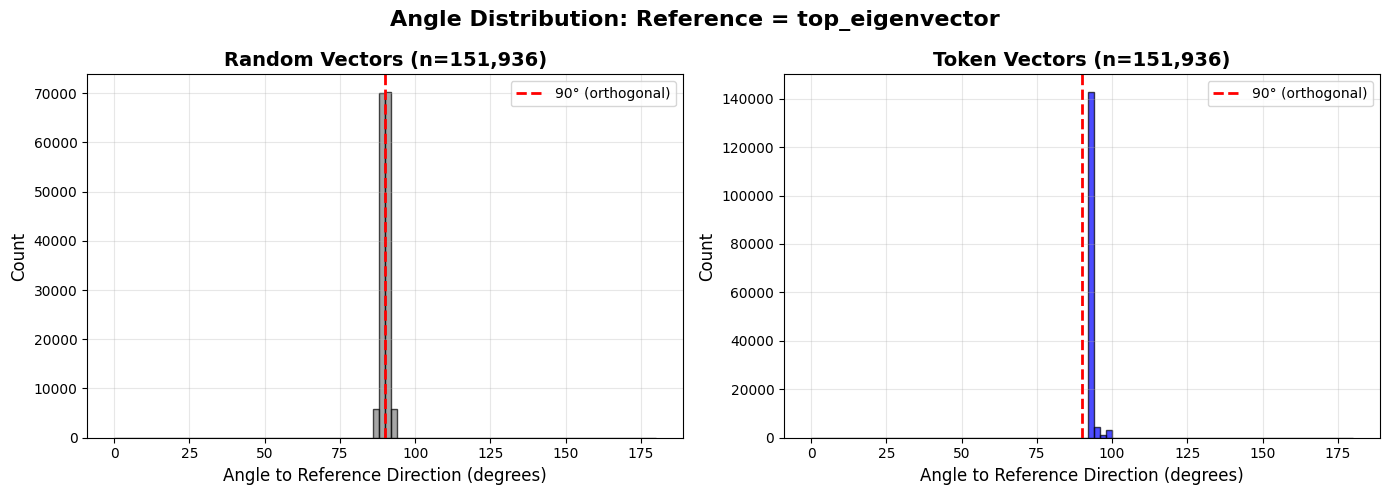


✓ Histograms plotted


In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

bins = np.linspace(0, 180, NUM_BINS + 1)

# Random vectors
ax1.hist(angles_random_deg, bins=bins, alpha=0.7, color='gray', edgecolor='black')
ax1.axvline(90, color='red', linestyle='--', linewidth=2, label='90° (orthogonal)')
ax1.set_xlabel('Angle to Reference Direction (degrees)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title(f'Random Vectors (n={vocab_size:,})', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Token vectors
ax2.hist(angles_tokens_deg, bins=bins, alpha=0.7, color='blue', edgecolor='black')
ax2.axvline(90, color='red', linestyle='--', linewidth=2, label='90° (orthogonal)')
ax2.set_xlabel('Angle to Reference Direction (degrees)', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title(f'Token Vectors (n={vocab_size:,})', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle(f'Angle Distribution: Reference = {REFERENCE_TYPE}', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Histograms plotted")

## Visualization: Overlaid Distributions

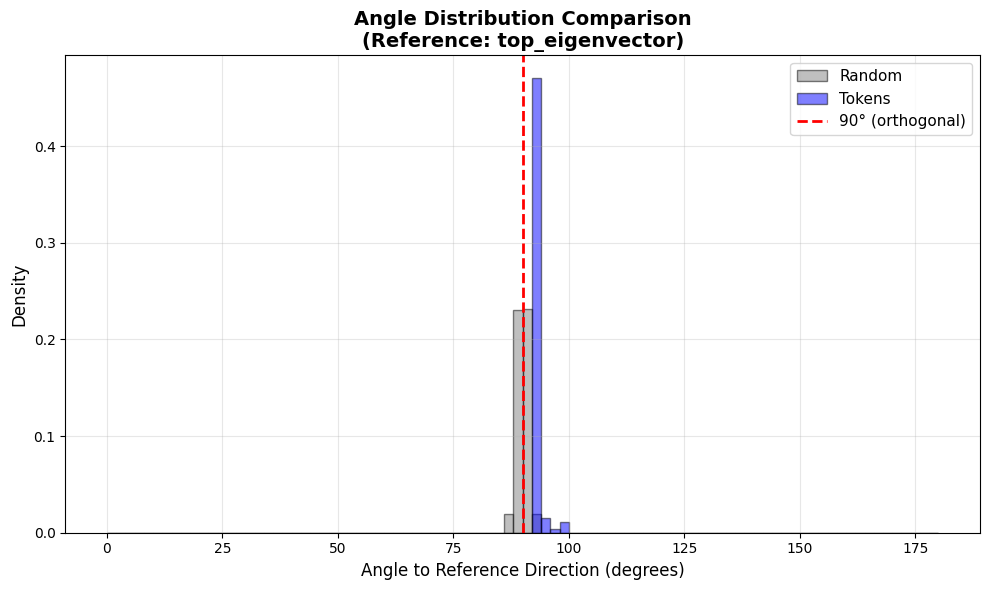


✓ Overlaid histogram plotted


In [55]:
fig, ax = plt.subplots(figsize=(10, 6))

bins = np.linspace(0, 180, NUM_BINS + 1)

ax.hist(angles_random_deg, bins=bins, alpha=0.5, color='gray', label='Random', edgecolor='black', density=True)
ax.hist(angles_tokens_deg, bins=bins, alpha=0.5, color='blue', label='Tokens', edgecolor='black', density=True)
ax.axvline(90, color='red', linestyle='--', linewidth=2, label='90° (orthogonal)')

ax.set_xlabel('Angle to Reference Direction (degrees)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'Angle Distribution Comparison\n(Reference: {REFERENCE_TYPE})', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Overlaid histogram plotted")

## Summary

**What we tested:** Whether token vectors have **preferred orientations** in semantic space, or are randomly scattered.

**Method:** Compared angle distributions of real tokens vs. random vectors, both measured against the top eigenvector of the causal metric tensor.

**Interpretation:**
- If distributions match → tokens are randomly oriented (no directional structure)
- If distributions differ → tokens have geometric structure (non-random placement)

**Expected baseline:** In high-dimensional space (~1333 effective dims), random vectors cluster around 90° to any reference direction, with narrow spread.

**What we learned:** [Run notebook to find out!]